In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline


**Gather Data for Seattle and Boston**

In [5]:
# read calendar seattle
df_cal_s = pd.read_csv('./calendar_seattle.csv')

# read calendar boston
df_cal_b = pd.read_csv('./calendar_boston.csv')


**Access Data**

In [6]:
df_cal_s.head() # seattle
df_cal_b.head() # boston 

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


Business Question 1
How is the distribution of the home prices and are there differences between both cities?

Data Preparation
- dropping na price values because the na values dont provide information for this analysis
- formatting datetime and using date as index
- categorizing the price values in ranges to make the plot more expressive

**Clean Data and analyze**

In [8]:
# clean price values
df_cal_s['price'] = df_cal_s['price'].replace({'\$':''}, regex = True).dropna().squeeze()
df_cal_s['price'] = pd.to_numeric(df_cal_s['price'], errors='coerce')

# format datetime
df_cal_s['date'] = pd.to_datetime(df_cal_s[['date']].squeeze())
df_cal_s = df_cal_s.set_index('date')

# calc avg price and occupancy rate
print('Seattle')
print("average price: ",df_cal_s['price'].mean())
print("occupancy rate (False: sold): ", df_cal_s['price'].isna().value_counts() / len(df_cal_s['price']) * 100)

# clean price values
df_cal_b['price'] = df_cal_b['price'].replace({'\$':''}, regex = True).dropna().squeeze()
df_cal_b['price'] = pd.to_numeric(df_cal_b['price'], errors='coerce')

# format datetime
df_cal_b['date'] = pd.to_datetime(df_cal_b[['date']].squeeze())
df_cal_b = df_cal_b.set_index('date')

# calc avg price and occupancy rate
print('Boston')
print("average price: ",df_cal_b['price'].mean())
print("occupancy rate (False: sold): ", df_cal_b['price'].isna().value_counts() / len(df_cal_b['price']) * 100)



Seattle
average price:  137.19222676140043
occupancy rate (False: sold):  False    67.010986
True     32.989014
Name: price, dtype: float64
Boston
average price:  192.45390955690283
occupancy rate (False: sold):  True     51.067775
False    48.932225
Name: price, dtype: float64


**Data understanding:**
- The average price is having a big different between both cities. Should be analysed if that´s changing with time.
- The utilization of the homes seems to be different as well. The percentage of _False_ means the homes are sold. So in Boston there are much more home that are free. The offer seems to be  much higher than the request.

**Visualise data**

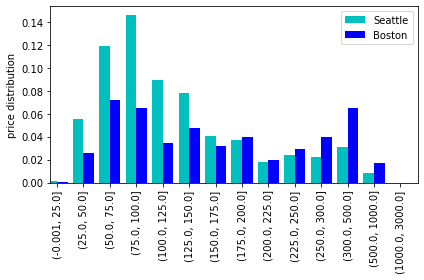

In [9]:
# making a figure
fig = plt.figure()

# getting categories
cat_s = pd.cut(df_cal_s['price'], bins=[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 300, 500, 1000, 3000], include_lowest=True)
cat_b = pd.cut(df_cal_b['price'], bins=[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 300, 500, 1000, 3000], include_lowest=True)

# count categories
cat_counts_s = cat_s.value_counts(sort=False)/len(df_cal_s)
cat_counts_b = cat_b.value_counts(sort=False)/len(df_cal_b)

# plot categories
cat_counts_s.plot(kind='bar', color='c', width = 0.4, position=1, label='Seattle', legend=True)
cat_counts_b.plot(kind='bar', color='b', width = 0.4, position=0, label='Boston', legend=True)

# plot layout
plt.ylabel("price distribution")
plt.tight_layout()
plt.show()

# save fig
fig.savefig('./occupany.png')

Are there price changings during the year and is it caused by any events?
- groupby date and using the mean value of all listings at the same time
- rotating the date to make the axis ticks readable

**Visualise data**

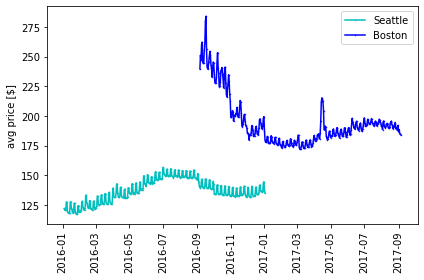

In [10]:
# Start and end of the date range to extract
start, end = '2014-01', '2023-01'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()

ax.plot(df_cal_s.loc[start:end, 'price'].groupby('date').mean(), marker='.', linestyle='-', color='c', markersize=1, label='Seattle')
ax.plot(df_cal_b.loc[start:end, 'price'].groupby('date').mean(), marker='.', linestyle='-', color='b', markersize=1, label='Boston')

ax.set_ylabel('avg price [$]')
ax.legend()
plt.xticks(rotation=90)
plt.tight_layout()
fig = ax.get_figure()
fig.savefig('./avg_price.png')

**Data understanding:**
- in Jan/Feb/March the prices are low but rise untill midsommer and go down again untill the winter months
- crazy price drop in Boston - maybe the prices were too high and the request for the homes were too low
- in April there must have been a local event in Boston causing this price peak

not used analysis - I wanted to make a plot about the utilization of the homes.

In [11]:
#print(df_cal_s)
df_s = df_cal_s[df_cal_s.available != 'f']
#df_b = df_cal_b[df_cal_s.available != 'f']
auslastung_s = df_s.groupby('date')['available'].value_counts()
#auslastung_b = df_b.groupby('date')['available'].value_counts()
print(auslastung)
auslastung_s.plot()
#auslastung_b.plot()

NameError: name 'auslastung' is not defined

Are there different weighted influences for the total review score value?
Making a linear model to predict the **review_scores_rating** to see which coefs are most 
significant. Comparing the output of seattle and boston.

including some functions of the lesson

In [12]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
            
    return df

In [13]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 

    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model

    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''

    # Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    # Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    # Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    # Split into explanatory and response variables
    X = df.drop(columns=[response_col], axis=1)
    y = df[response_col]

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) # Fit

    # Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    # Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [14]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

**Gather & Assess Data**

In [15]:
# Read in linstings data and store in a list
df_lis_s = pd.read_csv('./listings_seattle.csv')
df_lis_b = pd.read_csv('./listings_boston.csv')
df_lists = [df_lis_s, df_lis_b]

**Clean data - analyze and model**

In [17]:
# Loop for seattle and boston
for df_list in df_lists:
    
    # Filter for categorical variables
    df_cat = df_list.select_dtypes(include=[np.number])
    cat_cols_lst = df_cat.select_dtypes(include=['object']).columns

    # Value of interest:
    response_col = 'review_scores_rating' 
    
    # Clean and fit linear model
    test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_cat, 'review_scores_rating', cat_cols_lst, dummy_na=False)
    print("test_score, train_score: ", test_score, train_score)

    # Calc the coef weights
    coef_df = coef_weights(lm_model.coef_, X_train)

test_score, train_score:  -190.06134734358062 -212.10421669598512
test_score, train_score:  0.7075743811567 0.7986075716094313


**Visualize coefs with weights**

In [18]:
# relevant for my analysis are just the review scores
review_scores = ['review_scores_location','review_scores_value','review_scores_cleanliness','review_scores_checkin', 'review_scores_accuracy','review_scores_communication']

# Show the 20 most significant influencing variables
print(coef_df.head(20))

                           est_int     coefs  abs_coefs
25             review_scores_value  2.929826   2.929826
21       review_scores_cleanliness  2.703228   2.703228
22           review_scores_checkin  1.688343   1.688343
23     review_scores_communication  1.650156   1.650156
6                        longitude  1.495893   1.495893
20          review_scores_accuracy  1.473371   1.473371
5                         latitude  1.330772   1.330772
24          review_scores_location  0.612614   0.612614
9                         bedrooms  0.330221   0.330221
27               reviews_per_month -0.249368   0.249368
8                        bathrooms  0.199281   0.199281
7                     accommodates -0.189503   0.189503
10                            beds  0.175778   0.175778
12                 guests_included  0.088851   0.088851
15                 availability_30 -0.034356   0.034356
13                  minimum_nights -0.024564   0.024564
26  calculated_host_listings_count -0.017771   0

**Data understanding:**
- value and cleanliness are most important for customers in both countries
